Protocol used by Albertas to make this data: https://benchling.com/anavickas/f/lib_VNejBHt6-protocols/prt_2Bkfh557-meripseq/edit

HIV-1 IIIB Virus


https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607

We are starting from `fastq` files as raw data: 

In [76]:
list.files('fastq')

[1] "01_IN_23_NT_S3_L002_R1_001.fastq.gz"         
 [2] "01_IN_23_NT_S3_L002_trim.fastq.gz"           
 [3] "02_IN_23_METTL3_S4_L002_R1_001.fastq.gz"     
 [4] "02_IN_23_METTL3_S4_L002_trim.fastq.gz"       
 [5] "03_IN_23_METTL14_S5_L002_R1_001.fastq.gz"    
 [6] "03_IN_23_METTL14_S5_L002_trim.fastq.gz"      
 [7] "04_IN_23_Virma_S6_L002_R1_001.fastq.gz"      
 [8] "04_IN_23_Virma_S6_L002_trim.fastq.gz"        
 [9] "05_IN_23_WTAP_S7_L002_R1_001.fastq.gz"       
[10] "05_IN_23_WTAP_S7_L002_trim.fastq.gz"         
[11] "06_IN_24_NT_S8_L002_R1_001.fastq.gz"         
[12] "06_IN_24_NT_S8_L002_trim.fastq.gz"           
[13] "07_IN_24_METTL3_S9_L002_R1_001.fastq.gz"     
[14] "07_IN_24_METTL3_S9_L002_trim.fastq.gz"       
[15] "08_IN_24_METTL14_S10_L002_R1_001.fastq.gz"   
[16] "08_IN_24_METTL14_S10_L002_trim.fastq.gz"     
[17] "09_IN_24_Virma_S11_L002_R1_001.fastq.gz"     
[18] "09_IN_24_Virma_S11_L002_trim.fastq.gz"       
[19] "10_IN_24_WTAP_S12_L002_R1_001.fastq.gz"      
[20] "10_IN_24_WTAP_S12_L002_trim.fastq.gz"        
[21] "11_meRIP_23_NT_S13_L002_R1_001.fastq.gz"     
[22] "11_meRIP_23_NT_S13_L002_trim.fastq.gz"       
[23] "12_meRIP_23_METTL3_S14_L002_R1_001.fastq.gz" 
[24] "12_meRIP_23_METTL3_S14_L002_trim.fastq.gz"   
[25] "13_meRIP_23_METTL14_S15_L002_R1_001.fastq.gz"
[26] "13_meRIP_23_METTL14_S15_L002_trim.fastq.gz"  
[27] "14_meRIP_23_Virma_S16_L002_R1_001.fastq.gz"  
[28] "14_meRIP_23_Virma_S16_L002_trim.fastq.gz"    
[29] "15_meRIP_23_WTAP_S17_L002_R1_001.fastq.gz"   
[30] "15_meRIP_23_WTAP_S17_L002_trim.fastq.gz"     
[31] "16_meRIP_24_NT_S18_L002_R1_001.fastq.gz"     
[32] "16_meRIP_24_NT_S18_L002_trim.fastq.gz"       
[33] "17_meRIP_24_METTL3_S19_L002_R1_001.fastq.gz" 
[34] "17_meRIP_24_METTL3_S19_L002_trim.fastq.gz"   
[35] "18_meRIP_24_METTL14_S20_L002_R1_001.fastq.gz"
[36] "18_meRIP_24_METTL14_S20_L002_trim.fastq.gz"  
[37] "19_meRIP_24_Virma_S21_L002_R1_001.fastq.gz"  
[38] "19_meRIP_24_Virma_S21_L002_trim.fastq.gz"    
[39] "20_meRIP_24_WTAP_S22_L002_R1_001.fastq.gz"   
[40] "20_meRIP_24_WTAP_S22_L002_trim.fastq.gz"

## Trimming 

In [ ]:
%%bash 
cd ~/People/Judd/fastq
for f in *_L002_R1_001.fastq.gz; do  
    out=${f/\_S[1-9]*/.trim.fastq.gz}; 
    cutadapt -j 12 -q 15 -m 20 -a NNNAGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o ../trim/$out $f; 
done

## Alignment

Unmmaped reads for each `fastq` file saved for later alignment to HIV genome 

Human genome: `gencode.v28.annotation.gtf`

In [ ]:
%%bash 
STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/abe/genomes/hg38/
for f in trim/*.fastq.gz;do
    out=${f/.trim.fastq.gz/_};
    out=${out/trim/bam};
    STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 16 --genomeDir /rumi/shams/abe/genomes/hg38/ --readFilesIn $f --outFileNamePrefix $out --outReadsUnmapped Fastx;
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/abe/genomes/hg38/

HIV genome indices created by changing sequence provided by Judd to `.fa` format

In [ ]:
%%bash 
# make hiv genome indices 
bowtie2-build HIV/HIV.fa HIV/HIV
# Aligning to hiv genome 
for f in fastq_unmapped/*; do
	o=${f/.fastq/.bam};
 	o=${o/fastq_unmapped/bam};
 	bowtie2 --sensitive -N 1 -x HIV/HIV -U $f | samtools sort -o $o;
done

All `bam`  files (mapped to human genome or hiv genome) renamed in this format: 
> `<sample>.<species>.<treatment>.<input/m6A>.bam`

In [5]:
list.files('bam')ppattern =  = 

[1] "s23.hiv.METTL14.input.bam"       "s23.hiv.METTL14.input.bam.bai"  
 [3] "s23.hiv.METTL14.m6A.bam"         "s23.hiv.METTL14.m6A.bam.bai"    
 [5] "s23.hiv.METTL3.input.bam"        "s23.hiv.METTL3.input.bam.bai"   
 [7] "s23.hiv.METTL3.m6A.bam"          "s23.hiv.METTL3.m6A.bam.bai"     
 [9] "s23.hiv.NT.input.bam"            "s23.hiv.NT.input.bam.bai"       
[11] "s23.hiv.NT.m6A.bam"              "s23.hiv.NT.m6A.bam.bai"         
[13] "s23.hiv.Virma.input.bam"         "s23.hiv.Virma.input.bam.bai"    
[15] "s23.hiv.Virma.m6A.bam"           "s23.hiv.Virma.m6A.bam.bai"      
[17] "s23.hiv.WTAP.input.bam"          "s23.hiv.WTAP.input.bam.bai"     
[19] "s23.hiv.WTAP.m6A.bam"            "s23.hiv.WTAP.m6A.bam.bai"       
[21] "s23.human.METTL14.input.bam"     "s23.human.METTL14.input.bam.bai"
[23] "s23.human.METTL14.m6A.bam"       "s23.human.METTL14.m6A.bam.bai"  
[25] "s23.human.METTL3.input.bam"      "s23.human.METTL3.input.bam.bai" 
[27] "s23.human.METTL3.m6A.bam"        "s23.human.METTL3.m6A.bam.bai"   
[29] "s23.human.NT.input.bam"          "s23.human.NT.input.bam.bai"     
[31] "s23.human.NT.m6A.bam"            "s23.human.NT.m6A.bam.bai"       
[33] "s23.human.Virma.input.bam"       "s23.human.Virma.input.bam.bai"  
[35] "s23.human.Virma.m6A.bam"         "s23.human.Virma.m6A.bam.bai"    
[37] "s23.human.WTAP.input.bam"        "s23.human.WTAP.input.bam.bai"   
[39] "s23.human.WTAP.m6A.bam"          "s23.human.WTAP.m6A.bam.bai"     
[41] "s24.hiv.METTL14.input.bam"       "s24.hiv.METTL14.input.bam.bai"  
[43] "s24.hiv.METTL14.m6A.bam"         "s24.hiv.METTL14.m6A.bam.bai"    
[45] "s24.hiv.METTL3.input.bam"        "s24.hiv.METTL3.input.bam.bai"   
[47] "s24.hiv.METTL3.m6A.bam"          "s24.hiv.METTL3.m6A.bam.bai"     
[49] "s24.hiv.NT.input.bam"            "s24.hiv.NT.input.bam.bai"       
[51] "s24.hiv.NT.m6A.bam"              "s24.hiv.NT.m6A.bam.bai"         
[53] "s24.hiv.Virma.input.bam"         "s24.hiv.Virma.input.bam.bai"    
[55] "s24.hiv.Virma.m6A.bam"           "s24.hiv.Virma.m6A.bam.bai"      
[57] "s24.hiv.WTAP.input.bam"          "s24.hiv.WTAP.input.bam.bai"     
[59] "s24.hiv.WTAP.m6A.bam"            "s24.hiv.WTAP.m6A.bam.bai"       
[61] "s24.human.METTL14.input.bam"     "s24.human.METTL14.input.bam.bai"
[63] "s24.human.METTL14.m6A.bam"       "s24.human.METTL14.m6A.bam.bai"  
[65] "s24.human.METTL3.input.bam"      "s24.human.METTL3.input.bam.bai" 
[67] "s24.human.METTL3.m6A.bam"        "s24.human.METTL3.m6A.bam.bai"   
[69] "s24.human.NT.input.bam"          "s24.human.NT.input.bam.bai"     
[71] "s24.human.NT.m6A.bam"            "s24.human.NT.m6A.bam.bai"       
[73] "s24.human.Virma.input.bam"       "s24.human.Virma.input.bam.bai"  
[75] "s24.human.Virma.m6A.bam"         "s24.human.Virma.m6A.bam.bai"    
[77] "s24.human.WTAP.input.bam"        "s24.human.WTAP.input.bam.bai"   
[79] "s24.human.WTAP.m6A.bam"          "s24.human.WTAP.m6A.bam.bai"

## Peakcalling 

We are using RADAR package for meRIP data analysis ([see RADAR manual](https://scottzijiezhang.github.io/RADARmanual/workflow.html)). It will run over bam files for each enzyme treatment. `run_radar` function do it all for you :) 

In [2]:
library("RADAR")
run_radar <- function(enz, gtf,species='human', cutoff = 0.1, Beta_cutoff = 0.5,threads = 18){
    outputDir = paste("radar", species,enz, sep='/')
    radar <- countReads(
        samplenames = unlist(lapply (c('s23','s24'), paste, paste(species,c('NT',enz), sep='.'),sep='.')),
        gtf = gtf,
        bamFolder = "bam",
        modification = 'm6A',
        strandToKeep = "opposite",
        outputDir = outputDir,
        threads = threads,
        saveOutput = TRUE
    )
    saveRDS(radar, file = paste(outputDir,"raw.radar.rds",sep='/')) # ,compress = TRUE)
    radar <- normalizeLibrary(radar, boxPlot = FALSE)
    radar <- adjustExprLevel(radar)
    
    variable(radar) <- data.frame( Group =data.frame( Group = rep(c("Ctrl","Treated"),2)) )
    radar <- filterBins(radar,minCountsCutOff = 15)
    radar <- diffIP_parallel(radar, thread = threads)
    top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
    radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
    result <- results(radar)
    
    write.csv(results, paste(outputDir,'radar.bed',sep='/'), quote = FALSE, row.names = FALSE)
    saveRDS(radar, file = paste(outputDir,"radar.rds",sep='/')) # ,compress = TRUE)
}

### Run radar on human bam files 

In [41]:
gtf = "/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf"

In [ ]:
enz = 'METTL14'
run_radar(enz,gtf)

In [ ]:
enz = 'METTL3'
run_radar(enz,gtf)

[1] "Stage: index bam file bam/s23.human.Virma.input.bam"
[1] "Stage: index bam file bam/s23.human.Virma.m6A.bam"
[1] "Stage: index bam file bam/s24.human.Virma.input.bam"
[1] "Stage: index bam file bam/s24.human.Virma.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 26.6394029458364 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 4 is not drawn”

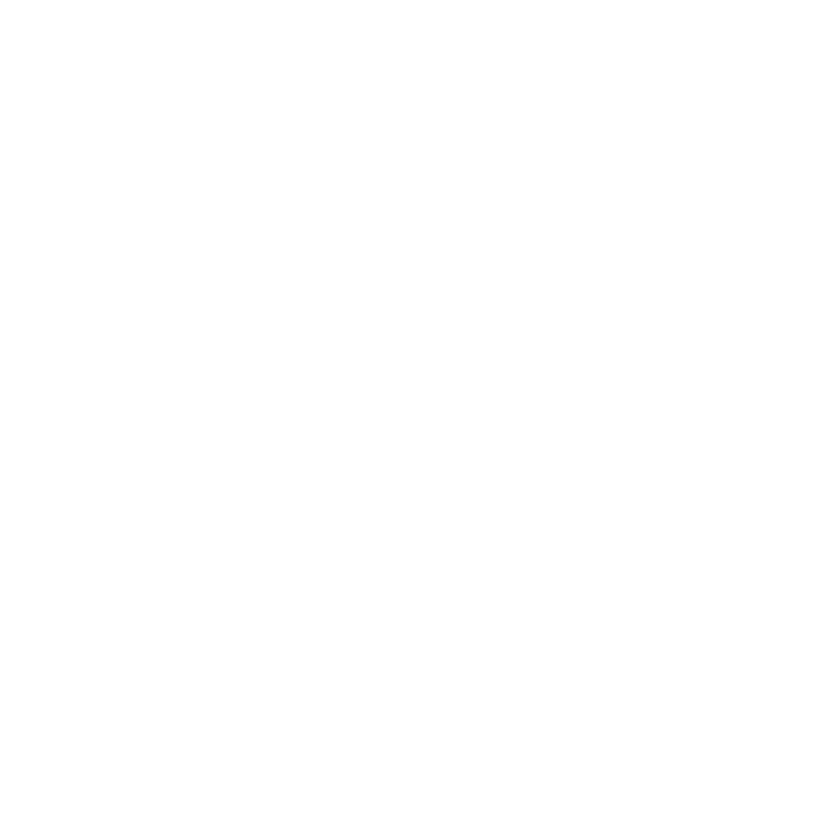

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.795921897888184 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.981886716683706 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 5488 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


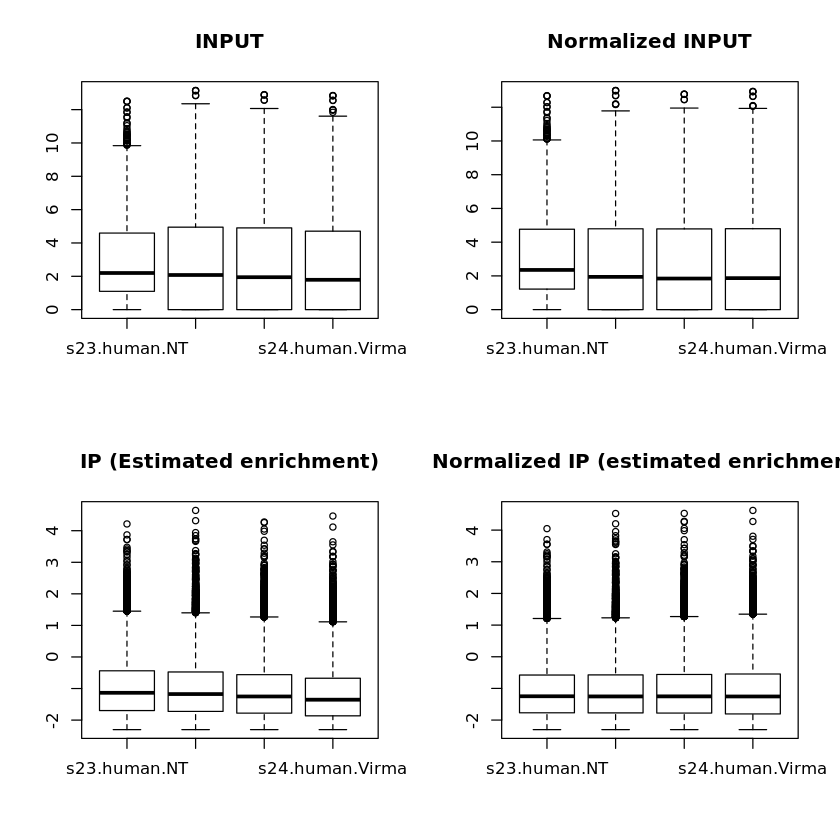

In [60]:
enz = 'Virma'
run_radar(enz,gtf)

[1] "Stage: index bam file bam/s23.human.WTAP.input.bam"
[1] "Stage: index bam file bam/s23.human.WTAP.m6A.bam"
[1] "Stage: index bam file bam/s24.human.WTAP.input.bam"
[1] "Stage: index bam file bam/s24.human.WTAP.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 29.0011871933937 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 1 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 4 is not drawn”

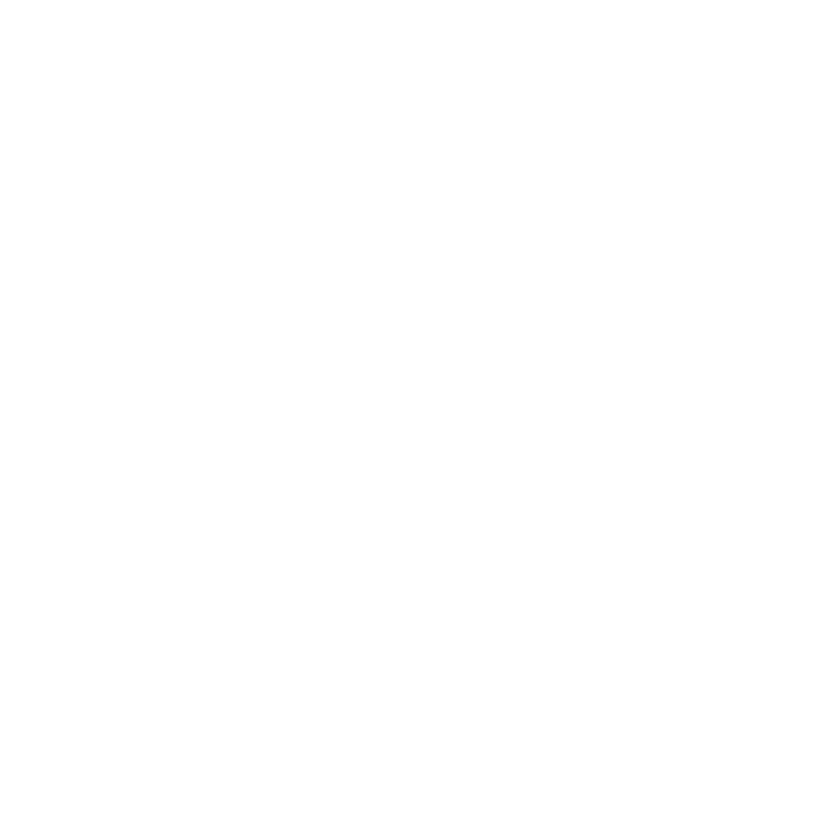

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.771063359578451 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 1.17677079439163 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 6961 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


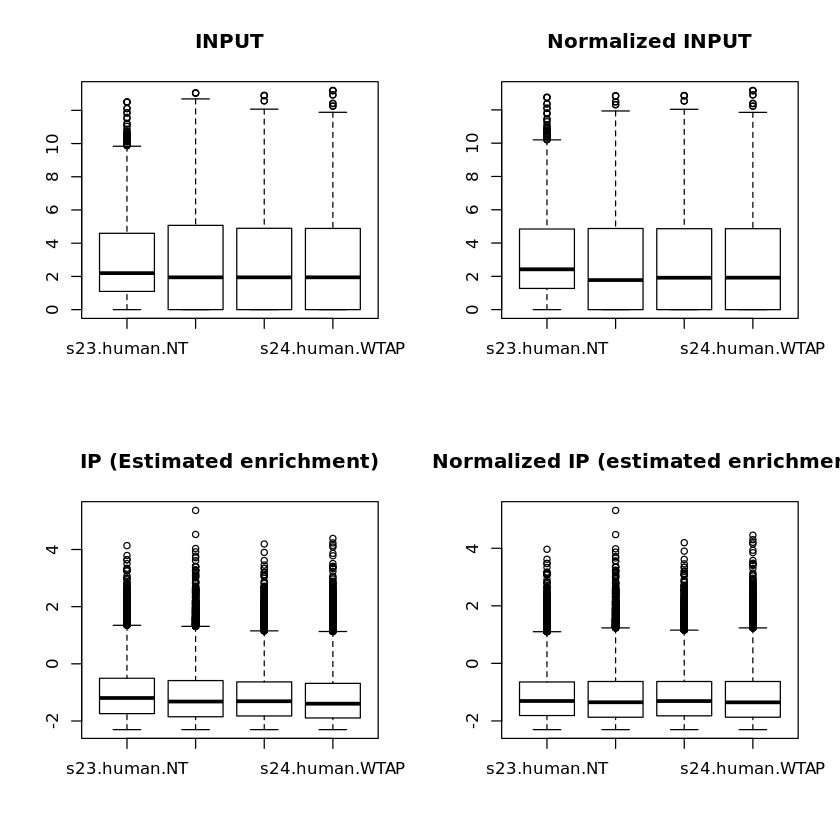

In [61]:
enz = 'WTAP'
run_radar(enz,gtf)

# Plots 
Using `plotHeatMap`, `plotPCAfromMatrix` and `peakDistribution` function from RADAR package:

In [16]:
for (enz in c('METTL14','METTL3','Virma','WTAP')){
    radar = readRDS(paste('radar/human/',enz,'/radar.rds',sep=''))

    pdf(paste("plots/radar.",enz,".Heatmap.pdf",sep=''), width=7, height=7, paper = "a4r")
    plotHeatMap(radar,covariates = FALSE)
    dev.off()

    png(paste("plots/radar.",enz,".Heatmap.png",sep=''))
    plotHeatMap(radar,covariates = FALSE)
    dev.off()

    p = peakDistribution(radar)
    ggsave(paste("plots/radar.",enz,".Distribution.png",sep=''), plot = p, device = 'png', dpi = 300, width = 5, height = 5)
    
    top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
    p = plotPCAfromMatrix(top_bins,group = unlist(variable(radar)) )
    ggsave(paste("plots/radar.",enz,".PCA.png",sep=''), plot = p, device = 'png', dpi = 300, width = 8, height = 5)
}

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.
Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.
There are 5488 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Returning normalized IP read counts.
Returning normalized IP read counts.
Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.
Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.
There are 6961 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Returning normalized IP read counts.
Returning normalized IP read counts.


In [ ]:
# cat radar.bed | awk -F, '{OFS=",";print $1,$2,$3,$4,"1",$6}' > radar.c.bed
# awk '{gsub(/\,/,"\t");print;}' radar.bed > radar.t.bed

# Control

Comparing to RADAR package, exomepeak also claculate coverage for only non threted samples. We used different conda `environment` for exomepeak (and it takes long time to run!!). 

In [ ]:
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("/rumi/shams/abe/People/Judd/bam")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=list.files(pattern='human.NT.m6A.bam$'),
    INPUT_BAM=list.files(pattern='human.NT.input.bam$'),
    OUTPUT_DIR='../exomepeak',
    EXPERIMENT_NAME='control'
)
saveRDS(res, paste('../exomepeak','control', 'results.rds', sep='/'))

In [72]:
files <- list.files(path = 'fc',pattern="NT.fc$") 
reps <- c(rep('s23',2),rep('s24',2))
ip <- c(rep('input',2),rep('m6A',2))
conds <- paste('NT',ip, sep='.')
all_conds <- paste(reps,'NT',ip, sep='.')
datalist <- lapply(files, function(x){read.table(file=paste('fc/', x, sep = "") ,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- paste ('human',m[,1],sep='-')
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- conds
colData <- data.frame(cond = conds, row.names=files)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
Warning message:
“Ignoring unknown aesthetics: label”Saving 6.67 x 6.67 in image
Warning message:
“Removed 24959 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 24959 rows containing missing values (geom_point).”Warning message:
“Removed 24959 rows containing missing values (geom_point).”

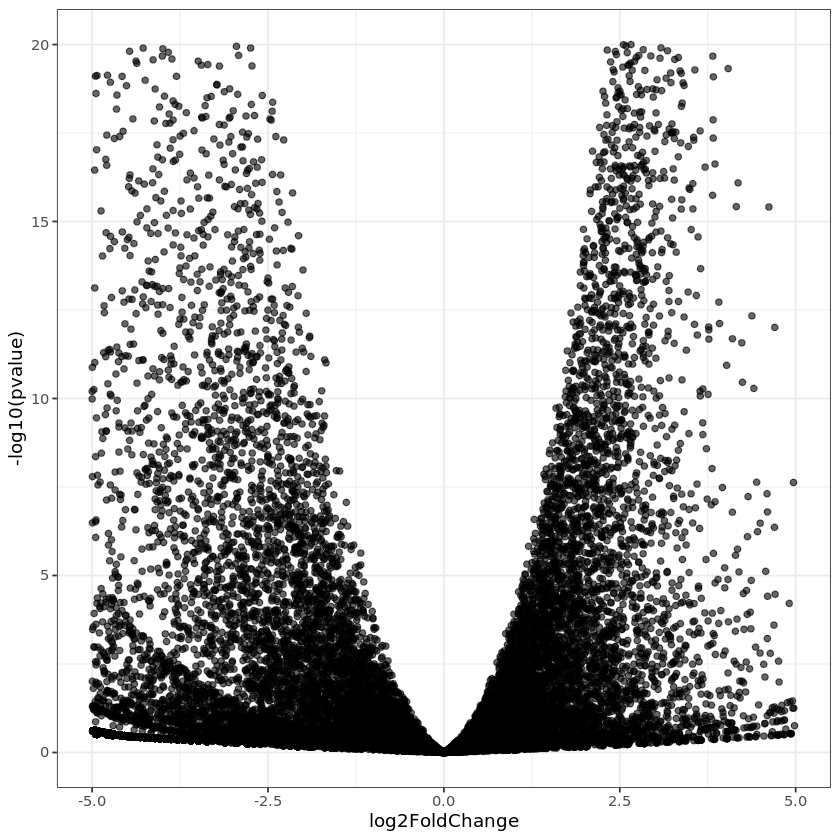

In [90]:
library(DESeq2, quietly = TRUE)
library(tidyverse, quietly = TRUE)

dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond <- relevel(dds$cond, ref="NT.input")
dds <- DESeq(dds)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
## PCA Plot 
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4,  label=name)) +
  geom_text(aes(label=name),hjust=0.5, vjust=-1.2) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  labs(colour="") +
  guides(size = FALSE)

# normalized counts 
ncu <- counts(dds, normalized=TRUE)
# Raw tabels 
write.table(ncu, file="deseq/gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=all_conds) 
write.table(m, file="deseq/gene_count_table_raw.txt", sep="\t", quote=FALSE, col.names=all_conds)

# model:
res <- results(dds)
write.table(res, "m6A_vs_input.txt", sep="\t", quote=FALSE, col.names=NA)
vol = data.frame(res) %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue))) + 
        geom_point(alpha = 6/10) + 
        xlim(c(-5,5)) + 
        ylim(c(0,20)) + 
        theme_bw() + 
        theme(legend.position="none")
ggsave(paste('plots/model_NT_Volcano.pdf',sep=''), plot = vol, device = 'pdf')
ggsave(paste('plots/model_NT_Volcano.png',sep=''), plot = vol, device = 'png')
print (vol)

# Plot _Guitar_ 
Now, let's draw metagene plots for control samples:

In [5]:
library(Guitar)

In [3]:
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


In [4]:
GuitarPlot(txTxdb = txdb,stBedFiles = list("exomepeak/control/peak.bed"),miscOutFilePrefix = "control")

[1] "20200223050452"
[1] "There are 203835 transcripts of 58381 genes in the genome."
[1] "total 203835 transcripts extracted ..."
[1] "total 94682 transcripts left after ambiguity filter ..."
[1] "total 94682 transcripts left after check chromosome validity ..."
[1] "total 11625 mRNAs left after component length filter ..."
[1] "total 56222 ncRNAs left after ncRNA length filter ..."
[1] "generate components for all tx"
[1] "generate components for mRNA"
[1] "generate components for lncRNA"
[1] "generate chiped transcriptome"
[1] "generate coverage checking ranges for tx"
[1] "generate coverage checking ranges for mrna"
[1] "generate coverage checking ranges for ncrna"
[1] "20200223050924"
[1] "import BED file exomepeak/control/peak.bed"
[1] "sample 10 points for Group1"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 2 out-of-bound ranges located on sequences
  ENST00000508832.2 and ENST00000583166.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”

[1] "start figure plotting for tx ..."
[1] "start figure plotting for mrna ..."
[1] "start figure plotting for ncrna ..."


## Motif analysis 

In [ ]:
%%bash 
cd exomepeak/human/control/
bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed peak.bed -split -fo peak.fa
# prepare fasta file for FIRE
perl /flash/hani/bin/Tools/prep_seqs_for_teiser_run.pl peak.fa peaks
# run FIRE --doskipdiscovery=1
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=motifs_of_interest.txt --oribiasonly=0
mv peaks_teiser.txt_FIRE/ motifs_of_interest_FIRE
# run FIRE --doskipdiscovery=0
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --oribiasonly=0

# run piranha for HIV bam files 

In [ ]:
%%bash
### m6A bam files ###
# Merge .bam files:
samtools merge -@ 12 piranha/hiv.m6A.bam bam/*hiv*m6A.bam
# sort the merged file >>> it's not making any change
samtools sort -@12 piranha/hiv.m6A.bam > piranha/hiv.m6A.srt.bam
# bam to bed
bedtools bamtobed -i piranha/hiv.m6A.srt.bam > piranha/hiv.m6A.srt.bed

### input bam files ###
# Merge .bam files:
samtools merge -@ 12 piranha/hiv.input.bam bam/*hiv*input.bam
# sort the merged file >>> it's not making any change
samtools sort -@12 piranha/hiv.input.bam > piranha/hiv.input.srt.bam
# bam to bet
bedtools bamtobed -i piranha/hiv.input.srt.bam > piranha/hiv.input.srt.bed

### run Piranha ###
Piranha -s -i 50 piranha/hiv.m6A.srt.bed piranha/hiv.input.srt.bed -o piranha/hiv.piranha.txt
# make new ref file
awk '{printf("%s\t%d\t%d\t%d\t1\t%s\n",$1,$2,$3, NR,$4)}' piranha/hiv.piranha.txt > piranha/final_piranha.bed
awk '{printf("%s\t%s\t%d\t%d\t%s\n",$4,$1,$2+1,$3,$6)}' piranha/final_piranha.bed > piranha/final_piranha.saf
### first line of piranha/final_piranha.saf removed 

In [167]:
# piranha <- read.delim('piranha/final_piranha.bed', header = FALSE, sep = "\t", dec = ".")

In [168]:
# library(seqinr)
# fa <- read.fasta(file = 'HIV/HIV.fa', as.string = TRUE)

In [169]:
# # fa[]
# piranha[1,2]

In [ ]:
%%bash
# make new reletive counts
for f in bam/*hiv*.m6A.bam; do
    out=${f/.bam/.piranha.fc};
    out=${out/bam/piranha\/fc};
    echo featureCounts -T 12 -O -F SAF -a piranha/final_piranha.saf -o $out $f;
done

for f in bam/*hiv*.input.bam; do
    out=${f/.bam/.piranha.fc};
    out=${out/bam/piranha\/fc};
    echo featureCounts -T 12 -O -F SAF -a piranha/final_piranha.saf -o $out $f;
done

(activate R kernel)

In [2]:
library(DESeq2)
library(ggplot2)
library(tidyverse)
library(pheatmap)

In [56]:
files <- list.files(path = "piranha/fc", pattern="fc$") 
reps <- c(rep('s23',10),rep('s24',10))
ip <- rep(c('input','m6A'),10)
enzymes <- rep(unlist(lapply(c('METTL14','METTL3','NT','Virma','WTAP'), rep, 2)),2)
conds <- ip
all_conds <- paste(
    reps,
    enzymes, 
    ip, 
    sep='.')
datalist <- lapply(files, function(x){read.table(file=paste('piranha/fc/', x, sep = "") ,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- paste ('hiv',m[,1],sep='-')
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- all_conds
colData <- data.frame(cond = conds, row.names=colnames(m))

comparing m6A/input for each knockdown to control


In [68]:
options(repr.plot.width=4, repr.plot.height=4)
all_vsd = list()
for (enz in c('METTL14','METTL3','Virma','WTAP')){
    icond = c(grep(enz,all_conds), grep('NT',all_conds) )
    mm <- m[,icond]
    colData <- data.frame(cond= conds[icond], row.names=colnames(mm))
    dds <- DESeqDataSetFromMatrix(countData = mm, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref='input')
    dds <- DESeq(dds)
    cds <- estimateDispersions(dds)
    vsd <- varianceStabilizingTransformation(cds)
    # Plot heatmap
    vsd_mat <- assay(vsd)
    all_vsd[[enz]] = data.frame(vsd_mat)
    
#     # normalized counts 
#     ncu <- counts(dds, normalized=TRUE)
#     # Raw tabels 
#     write.table(ncu, file=paste("piranha/results/",enz,".hiv.","gene_count_table_DE2norm.txt", sep=''), sep="\t", quote=FALSE, col.names=colnames(mm)) 
#     write.table(mm, file=paste("piranha/results/",enz,".hiv.","gene_count_table_raw.txt", sep=''), sep="\t", quote=FALSE, col.names=colnames(mm))
#     # model:
#     res <- results(dds)
#     write.table(res, paste("piranha/results/",enz,".hiv.","input_vs_m6A.txt", sep=''), sep="\t", quote=FALSE, col.names=NA)

    
    ## Volcano plot 
#     vol = data.frame(res) %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue))) + 
#             geom_point(alpha = 6/10) + 
#             xlim(c(-5,5)) + 
#             ylim(c(0,20)) + 
#             theme_bw() + 
#             theme(legend.position="none")
#     ggsave(paste('results/plots/model_',i,'_Volcano.pdf',sep=''), plot = vol, device = 'pdf')
#     print (vol)
}

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automa

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


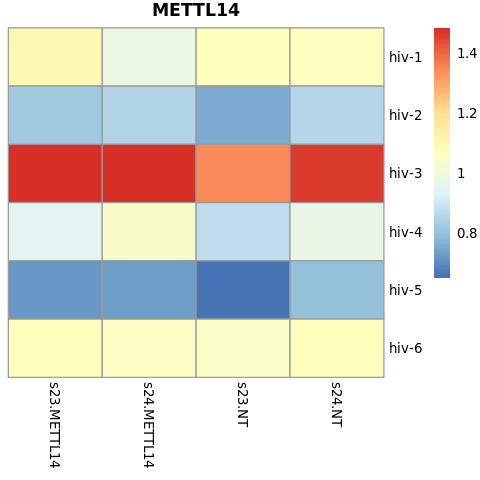

Saving 6.67 x 6.67 in image


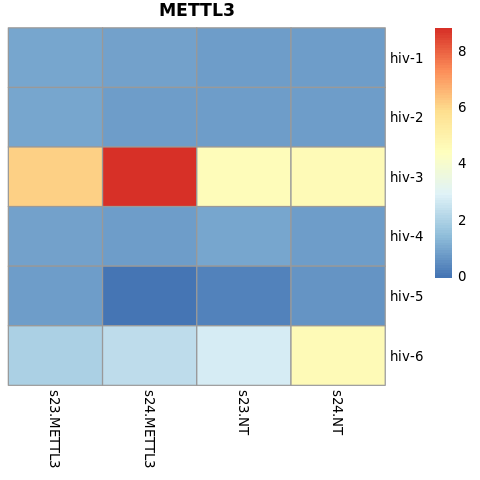

Saving 6.67 x 6.67 in image


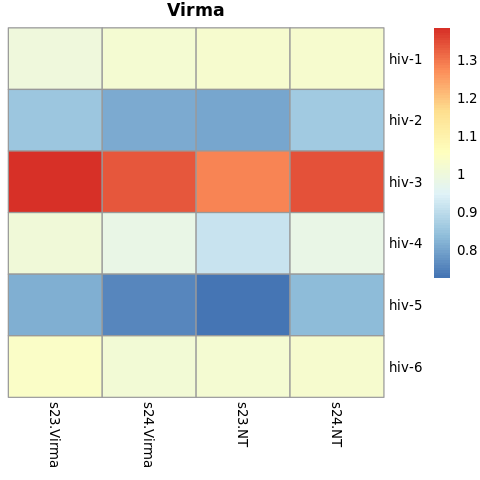

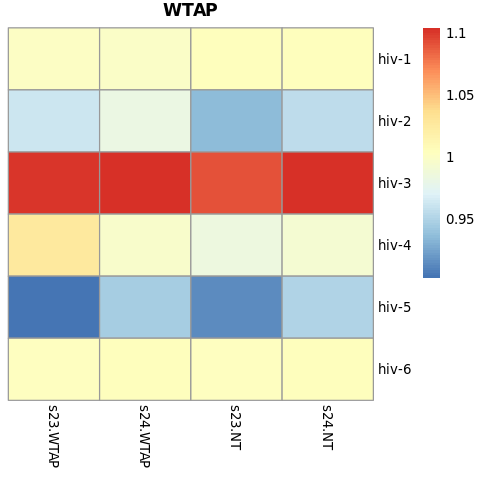

In [162]:
for (enz in c('METTL14','METTL3','Virma','WTAP')){
    vsd = all_vsd[[enz]]
    new = data.frame(row.names = rownames(vsd))
    for (i in 2*(1:4)){new[[substr(colnames(vsd)[i],1,nchar(colnames(vsd)[i])-4)]] = vsd[,i]/vsd[,i-1]}
    h1 <- pheatmap(as.matrix(new), fontsize = 8, cluster_rows = FALSE, cluster_cols=FALSE, main=enz)
    ggsave(paste('plots/hiv.',enz,'_Heatmap.pdf',sep=''), plot = h1, device = 'pdf', dpi = 300)
    ggsave(paste('plots/hiv.',enz,'_Heatmap.png',sep=''), plot = h1, device = 'png', dpi = 300,width = 3, height = 3)
}

In [8]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/RADAR/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RADAR_0.2.1                 qvalue_2.18.0              
 [3] RcppArmadillo_0.9.800.4.0   Rcpp_1.0.3                 
 [5] RColorBrewer_1.1-2          gplots_3.0.1.2             
 [7] doParallel_1.0.15           iterators_1.0.12           
 [9] foreach_1.4.7             

## Similar paper 
> [Dynamics of the human and viral m6 A RNA methylomes during HIV-1 infection of T cells](https://www.nature.com/articles/nmicrobiol201611.pdf?proof=t)
[GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE74016)

They’re using [pLAI.2 HIV](https://aidsreagent.org/reagentdetail.cfm?t=molecular_clones&id=47) but Judd have used [HIV-1 IIIB Virus](https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607)

Data in this paper might be useful to compare it with Judd’s data. They have used different pipelines to analyze data at that time. I'm downloading data using [SRA Toolkit](https://www.ncbi.nlm.nih.gov/sra/docs/sradownload/#download-sequence-data-files-usi)


https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP064809

In [ ]:
%%bash 
STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/abe/genomes/hg38/
mkdir peer/bam
for f in peer/fastq/*;do
    out=${f/fastq/bam};
    echo STAR --outSAMtype BAM SortedByCoordinate --runThreadN 16 --genomeDir /rumi/shams/abe/genomes/hg38/ --readFilesIn $f --outFileNamePrefix $out.bam --outReadsUnmapped Fastx;
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/abe/genomes/hg38/